In [75]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [76]:
from src.pipeline.dataloader import DataLoader, DataLoaderConfig
from src.pipeline.frame.filter import FrameFilters
from src.pipeline.frame.transformer import FrameTransformers
from src.pipeline.taskloader import TaskLoader, TaskFrame, TaskLoaderConfig
from src.pipeline.trainer import Trainer

from src.parsers.cv_parser import to_cv_params, parse_cv_result, fmt_cv_results, _fmt_regressor
from src.utils.test_result_store import TestResultStore
from src.visualizers.prediction_figures import PredictionFigures
from src.visualizers.test_figures import TestFigures
from src.visualizers.cv_figures import CVFigures

from src.settings.strategy import Strategy
from src.settings.tier import Tier

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

In [77]:
DataLoader.DATA_FOLDER = './data/training/'
dl: DataLoader = DataLoader()
tl: TaskLoader = TaskLoader()

In [78]:
def get_dataset(
    data_config: DataLoaderConfig,
    task_config: TaskLoaderConfig,
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
):
    dl.prepare_dataloader(data_config),
    df = dl.get_dataframe()
    tl.prepare_taskloader(task_config)
    gen = tl.prepare_task(df).build(strategy)
    tf: TaskFrame = next(gen)
    return tf

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')



precursor_dataset_raw = get_dataset(
    data_config=DataLoaderConfig( additional_filters=["is_precursor"]),
    task_config=TaskLoaderConfig(),
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
)


precursor_dataset = get_dataset(
    data_config=DataLoaderConfig(additional_transforms=["log_fold_change_protein"], additional_filters=["is_precursor"]),
    task_config=TaskLoaderConfig(),
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
)


ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3c921963a0>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3c92258d30>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3c921963a0>>])


In [126]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
                "facecolor": "white",
            }
        )
        sns.set_style(
            'whitegrid',
            rc={
                'axes.edgecolor': 'black'
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

# Visualizations
1. How many measures do I have per metabolite
2. What are the range for each precursor metabolite
3. For pyr, pep, dhap what are the knockouts that tricker the highest change

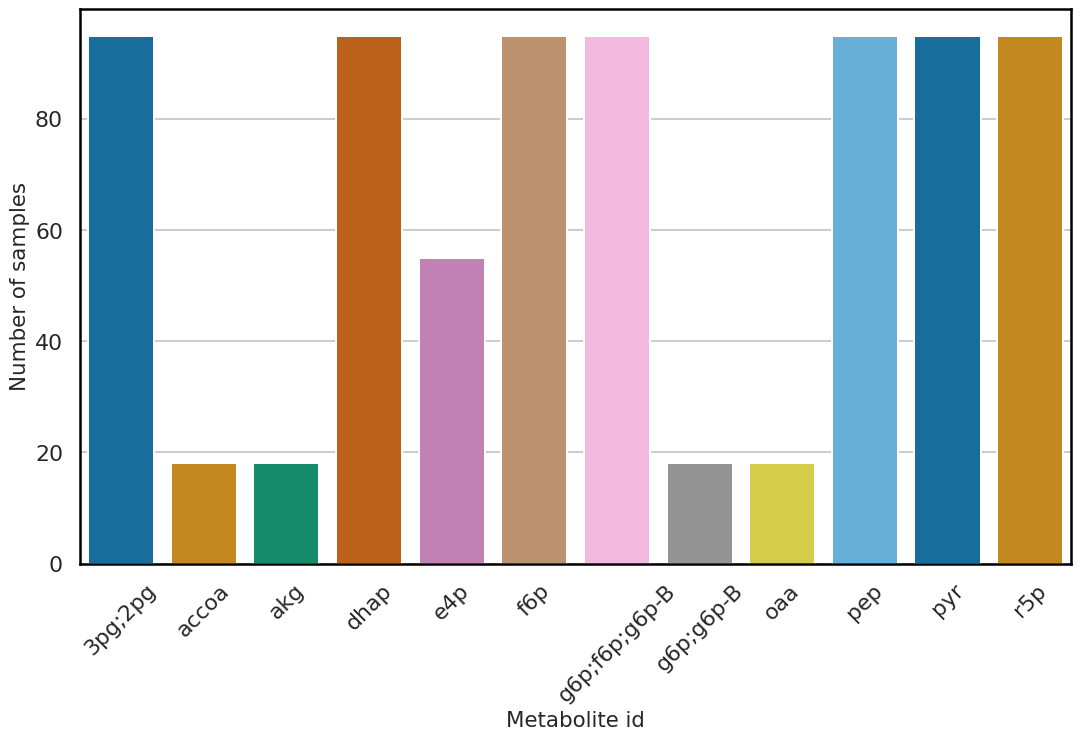

In [130]:
set_context(MODE)
g = sns.countplot(
    data=precursor_dataset.x.reset_index(),
    x='metabolite_id',
    palette='colorblind',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Number of samples")

save_fig(path=f"./images/{MODE}/explorative/", name="count_per_precursor_metabolite")

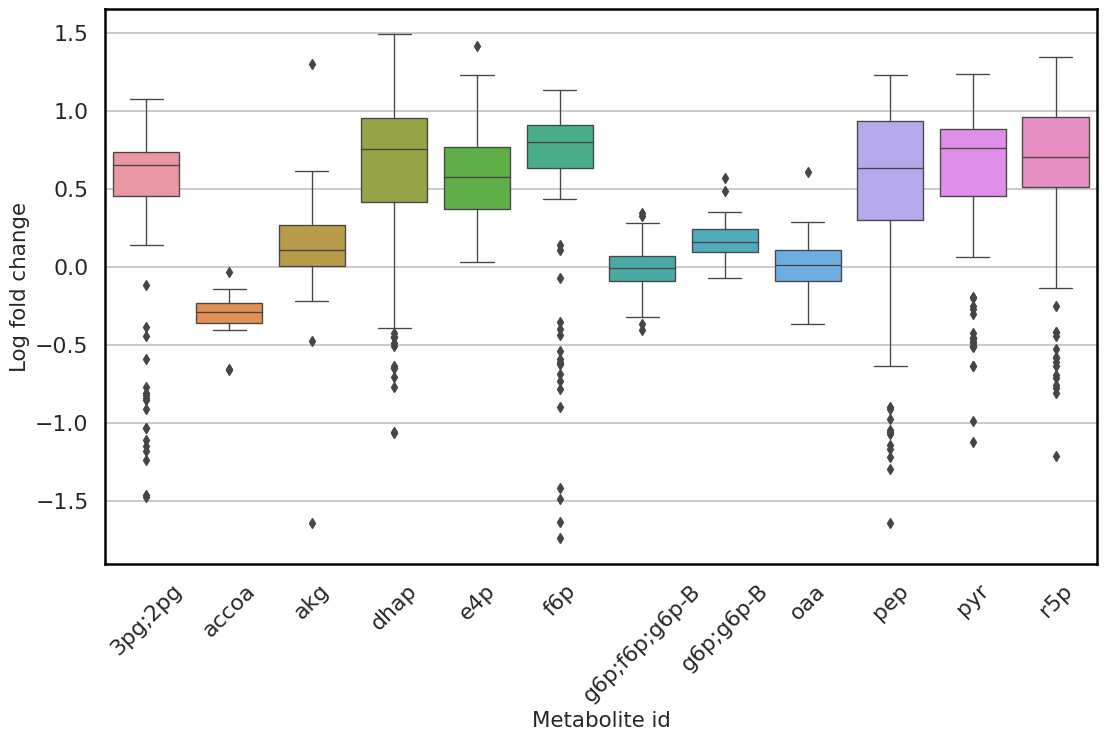

In [121]:
set_context(MODE)
g = sns.boxplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration',
    linewidth=1,
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Log fold change")

save_fig(path=f"./images/{MODE}/explorative/", name="boxplot_per_precursor_metabolite_fc")

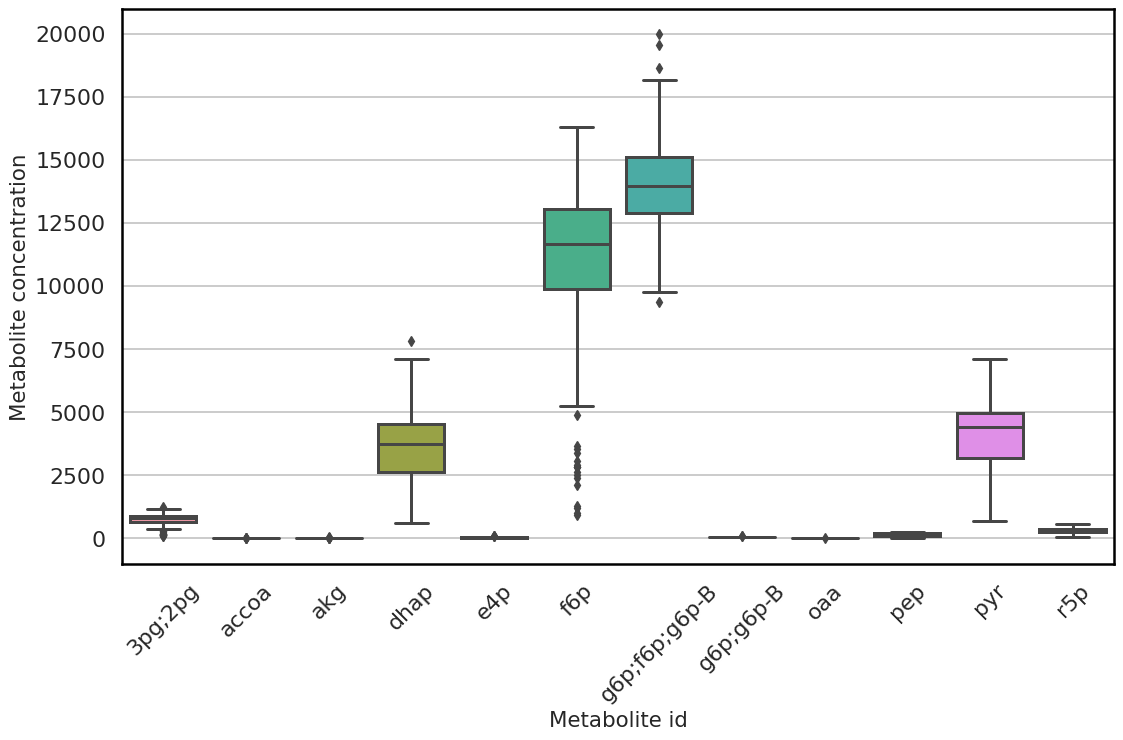

In [129]:
set_context(MODE)

g = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration'
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Metabolite concentration")
save_fig(path=f"./images/{MODE}/explorative/", name="boxplot_per_precursor_metabolite")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


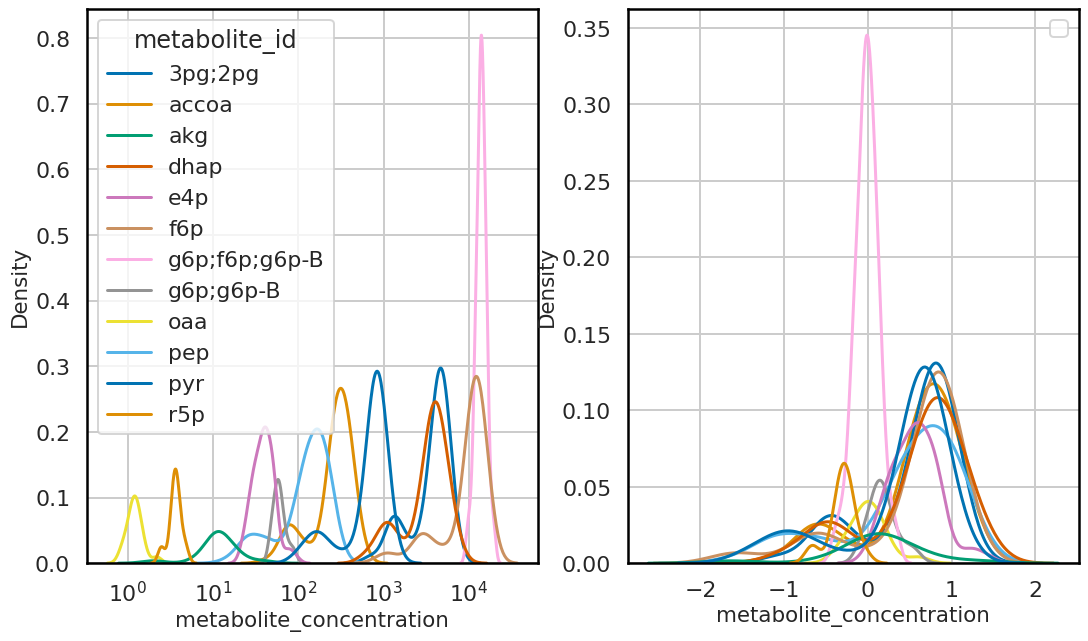

In [128]:
fig = set_context(MODE)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.kdeplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    log_scale=(True),
    fill=False,
    ax=ax1,
    palette='colorblind',
)

sns.kdeplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    fill=False,
    ax=ax2,
    palette='colorblind',
)

plt.legend()

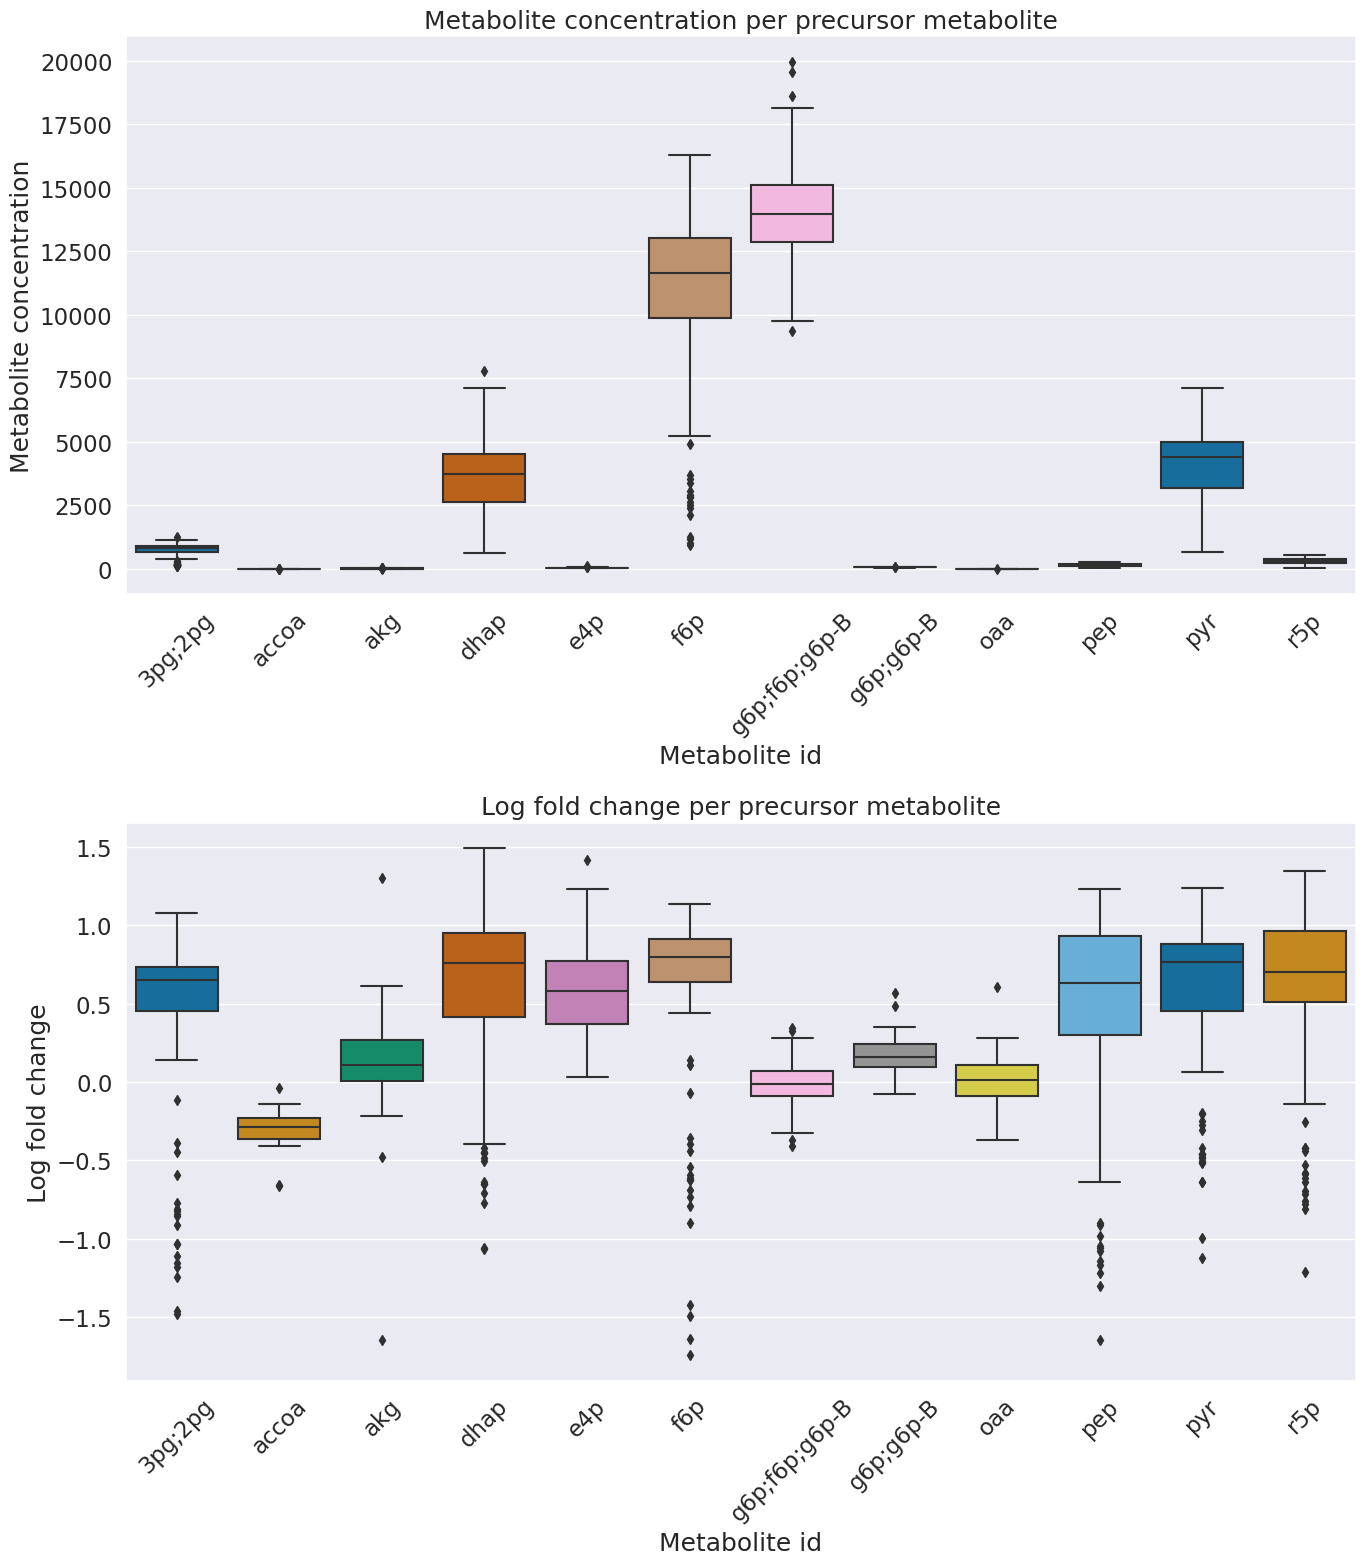

In [84]:
sns.set(font_scale=1.5)
fig, ((ax3, ax4)) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))

g3 = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax3,
    palette='colorblind',
)

g3.axes.set_xticklabels(g3.axes.get_xticklabels(), rotation=45)
g3.set(xlabel="Metabolite id", ylabel="Metabolite concentration", title="Metabolite concentration per precursor metabolite")

g4 = sns.boxplot(
    data=precursor_dataset.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax4,
    palette='colorblind',
)

g4.axes.set_xticklabels(g4.axes.get_xticklabels(), rotation=45)
g4.set(xlabel="Metabolite id", ylabel="Log fold change", title="Log fold change per precursor metabolite")
plt.tight_layout()

plt.savefig('./images/explorative/boxplot_log_fold_transformation.svg')
plt.savefig('./images/explorative/boxplot_log_fold_transformation.png')

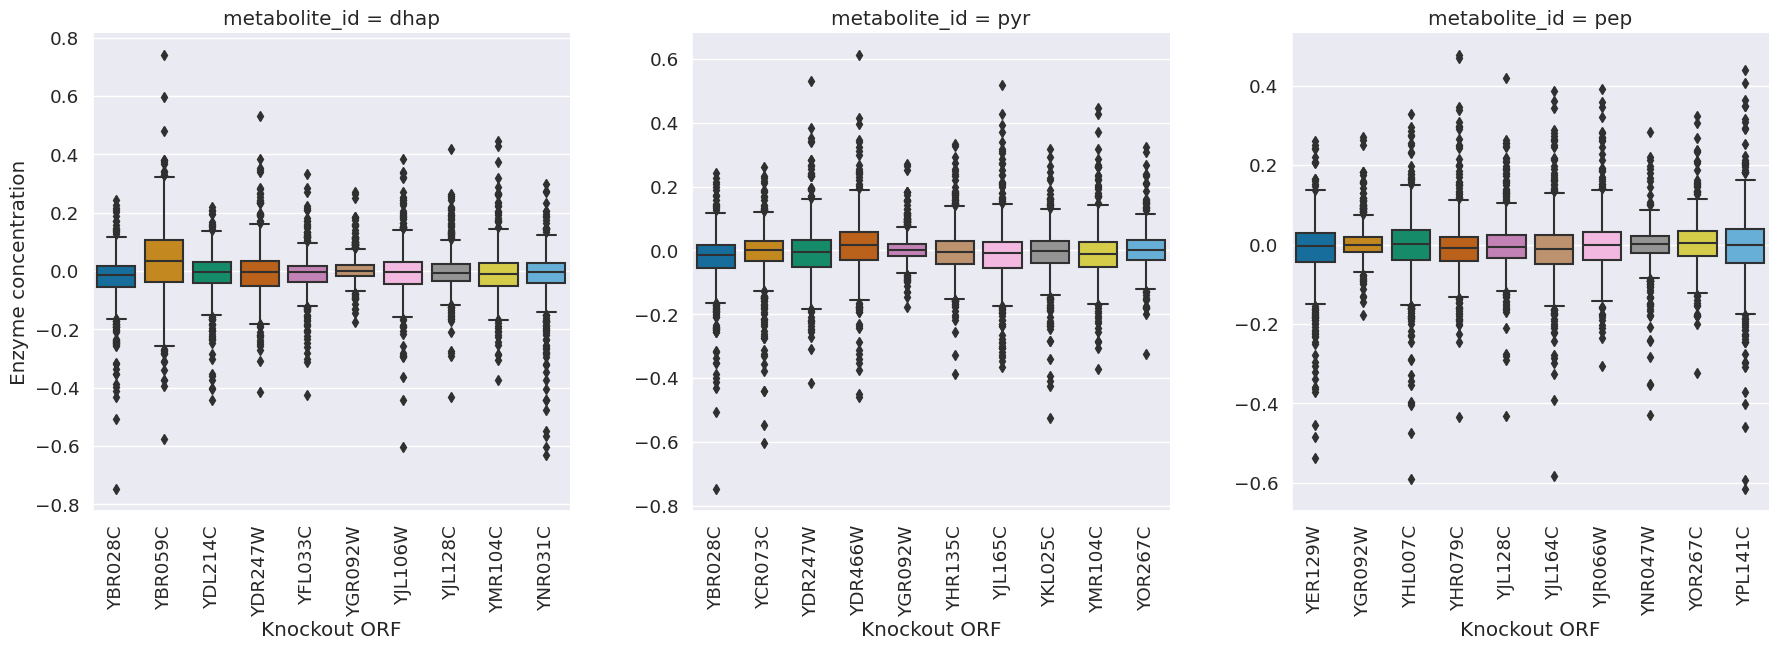

In [85]:
sns.set(font_scale=1.2)
_df_x = precursor_dataset.x[precursor_dataset.x.index.isin(['pep', 'pyr', 'dhap'], level=1)]
_df_y = precursor_dataset.y[_df_x.index].abs().sort_values(ascending=False).groupby('metabolite_id').head(10)
_df_x = _df_x.loc[_df_y.index]
_df = _df_x.T.stack([0, 1]).to_frame('enzyme_concentration').reset_index()

def mapper(*args, **kwargs):
    df = kwargs['data']
    sns.boxplot(
        data=df,
        y='enzyme_concentration',
        x='KO_ORF',
        palette='colorblind'
    )

g = sns.FacetGrid(
    _df, 
    col='metabolite_id', 
    col_wrap=10,
    sharex=False,
    sharey=False,
    height=6
)
g.map_dataframe(mapper)

for axes in g.axes.flatten():
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.set_axis_labels(x_var="Knockout ORF", y_var="Enzyme concentration")

plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.svg', bbox_inches="tight")
plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.png', bbox_inches="tight")